<h1>MINI-PROYECTO</h1>
<p>Nombre: Javier Cueto</p>
<p>Asignatura: Aprendizaje de Maquina</p>

<h2>INTRODUCCION</h2>
<p>Este mini-proyecto utiliza como dataset las características de pingüinos, en las que encontramos su especie, sexo, isla, ect. Para trabajar los datos utilizaremos aprendizaje no supervisado para descubrir cómo se agrupan los pingüinos dependiendo de sus medidas físicas. Luego, utilizaremos aprendizaje supervisado para predecir la especie de los pingüinos.</p>

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Primero Cargamos los datos
df = pd.read_csv('penguins_size.csv')

# Buscamos los valores nulos
print(df.info())

# Reemplazamos los datos faltantes con su mediana.
col_numerica = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
for col in col_numerica:
    mediana = df[col].median()
    df[col] = df[col].fillna(mediana)
# eliminamos los categoricos faltantes
df.dropna(inplace=True)

print("\nValores nulos después de la imputación:")
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB
None

Valores nulos después de la imputación:
species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


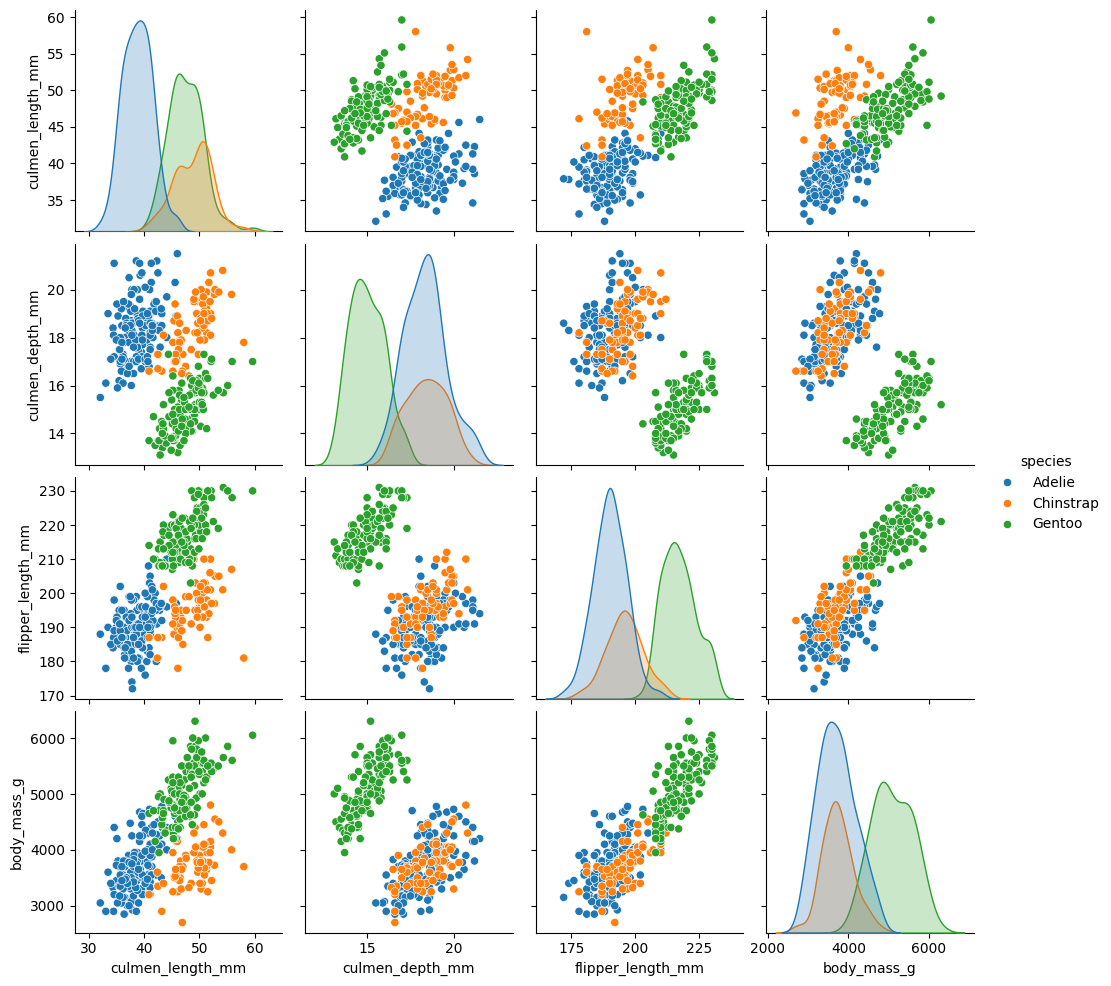

In [24]:
# Vemos las relaciones
sns.pairplot(df, hue='species')
plt.show()

<h2>APRENDIZAJE NO SUPERVISADO</h2>
<p>Utilizando k-means y PCA, comprobaremos si podemos identificar los grupos que existen en los datos, además de poder visualizarlos de forma clara.</p>

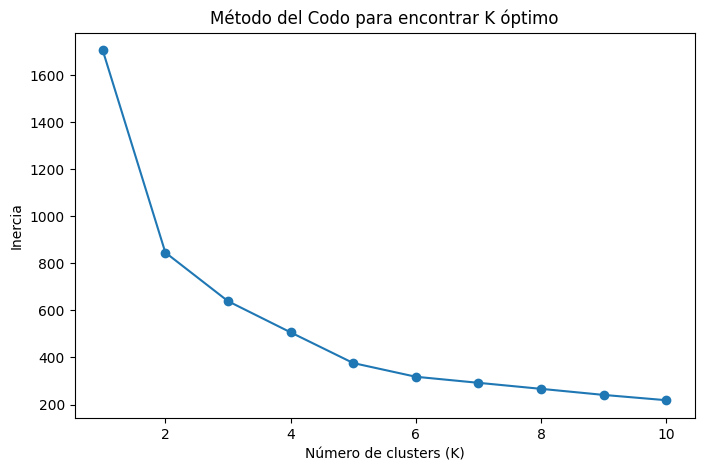

In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Definimos las variables X e Y
X = df.drop('species', axis=1)
y = df['species']

# Prepocesamos los datos para que puedan trabajar k-Means y PCA de forma correcta
# Esto se hara para los valores numericos y categoricos
numeric_features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_features = ['island', 'sex']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Utilizamos el metodo del codo para encontrar el valor de K perfecto para K-means
inertia = []
processed_X = preprocessor.fit_transform(X)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(processed_X)
    inertia.append(kmeans.inertia_)
# Graficamos
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo para encontrar K óptimo')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.show()


<p>Como podemos visualizar en el gráfico, la cantidad optima de cluster que podemos utilizar son 3 o 4. En nuestro caso utilizaremos 3 clusters, ya que son tres las especias de pingüinos. Lo que sigue es trabajar con k=3 para el modelo de k-Means.</p>

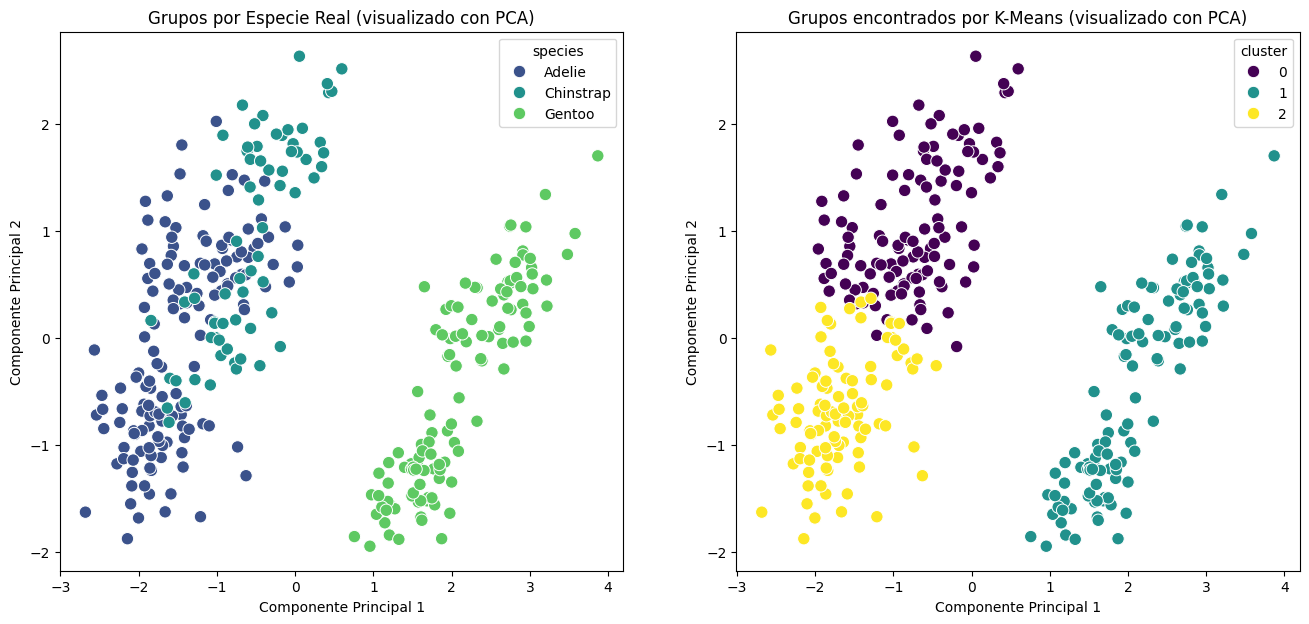

In [26]:
# Entrenamos el modelo con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(processed_X)

# utilizamos PCA=2 para poder visualizar los datos a traves de sus dos componentes principales
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(processed_X)
df_pca = pd.DataFrame(data=X_pca, columns=['Componente Principal 1', 'Componente Principal 2'])
df_pca['species'] = y.values
df_pca['cluster'] = df['cluster'].values

# 5. Visualizar K-Means vs. Especies Reales usando PCA
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

sns.scatterplot(data=df_pca, x='Componente Principal 1', y='Componente Principal 2', hue='species', palette='viridis', ax=ax1, s=80)
ax1.set_title('Grupos por Especie Real (visualizado con PCA)')

sns.scatterplot(data=df_pca, x='Componente Principal 1', y='Componente Principal 2', hue='cluster', palette='viridis', ax=ax2, s=80)
ax2.set_title('Grupos encontrados por K-Means (visualizado con PCA)')
plt.show()

<p>K-Means logro identificar los 3 cluster de manera clara. Los 3 grupos corresponden a las 3 especies, evidenciando que existe una fuerte relacion entre entre las caracteristicas fisicas y su especie.</p>

<h2>APRENDIZAJE SUPERVISADO</h2>
<p>Para el aprendizaje supervisado, utilizaremos como etiqueta la categoría de "species". La idea es que un nuevo pingüino pueda ser relacionado por sus medidas a una especie.</p>

Accuracy Inicial: 1.0000

Clasificación Inicial:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        37
   Chinstrap       1.00      1.00      1.00        17
      Gentoo       1.00      1.00      1.00        30

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84


Matriz de Confusión Inicial:


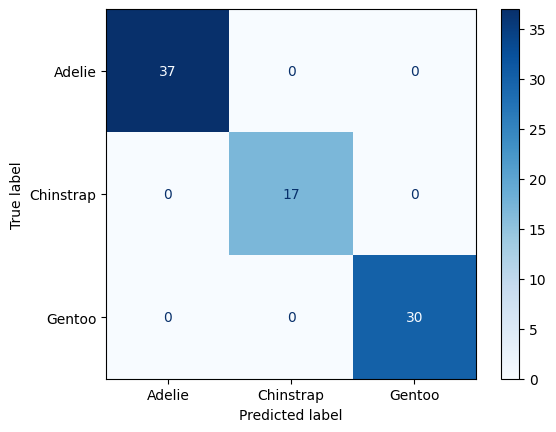

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# transformamos la variable "species" a valor numerico
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Dividimos los datos ya procesados
X_train, X_test, y_train, y_test = train_test_split(
    processed_X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

# creamos el modelo y lo entrenamos con los datos ya procecsados
rf_model_inicial = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model_inicial.fit(X_train, y_train)

# Evaluamos el modelo
y_pred_rf = rf_model_inicial.predict(X_test)

print(f"Accuracy Inicial: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClasificación Inicial:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# Visualizamos la Matriz de Confusión
print("\nMatriz de Confusión Inicial:")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=le.classes_, cmap='Blues')
plt.show()

<p>Los resultados del modelo Random Forest entregaron unos excelentes resultados, alcanzando una precisión alta.</p>

<h2>EVALUACION</h2>

In [28]:
# Definimos el modelo y los parametros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}
rf_model_opt = RandomForestClassifier(random_state=42)

# configuramos GridSearch
grid_search = GridSearchCV(estimator=rf_model_opt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# mostramos los datos obtenidos
print("\nResultados de la Optimización")
print("Mejores parámetros encontrados: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print(f"\nAccuracy del modelo optimizado: {accuracy_score(y_test, y_pred_best):.4f}")
print("\nClasificación del Modelo Optimizado:")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits

Resultados de la Optimización
Mejores parámetros encontrados:  {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 50}

Accuracy del modelo optimizado: 0.9881

Clasificación del Modelo Optimizado:
              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.99        37
   Chinstrap       0.94      1.00      0.97        17
      Gentoo       1.00      1.00      1.00        30

    accuracy                           0.99        84
   macro avg       0.98      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84



<p>Los resultados fueron parecidos al modelo inicial, pero el optimizado solo utiliza 50 árboles, siendo más eficiente.</p>

<p>---------------------------------------------------------------------------------------</p>
<p>Se determino que las medidas físicas de los pingüinos son excelentes para predecir la especie.</p>
